In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice, MockDevice, DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform
from pulser_simulation import QutipEmulator, SimConfig
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import matplotlib as mpl
from matplotlib.patches import Rectangle

Quelques définitions de variables

In [2]:
device_used = MockDevice

On définit tout d'abord quelques fonctions utiles

In [3]:
#sum the bits in a given bitstring
def sum_bit(string_in):
    list_b = [int(string_in[i]) for i in range(len(string_in))]
    return np.sum(list_b)

#check if a given bitstring is an independent set, i.e. no two nodes on an edge are selected
def check_IS(key_string, graph):
    state = [int(key_string[k]) for k in range(len(key_string))]
    bool_val = True
    for ed in graph.edges():
        val = (state[int(ed[0])] + state[int(ed[1])])
        if val == 2:
            bool_val = False
    return bool_val

# Création du graphe

Dans la cellule suivante, vous pouvez télécharger le graph pré-construit, ou vous amuser à en créer des aléatoires avec la ligne commentée. 

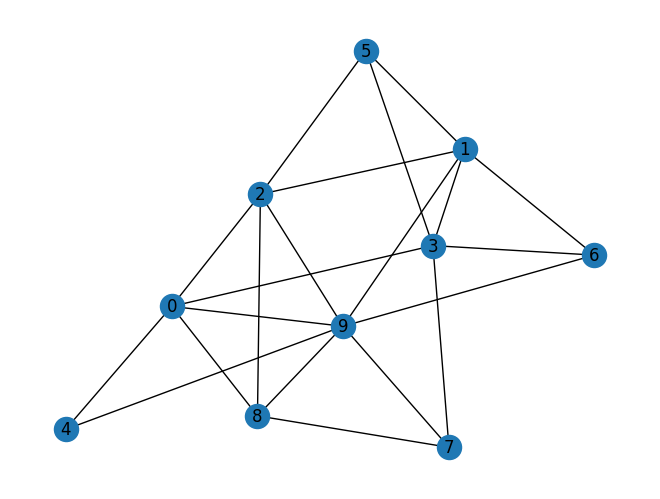

In [13]:
seed = 42
N = 10 #number of sites
#create a random graph. p is the density of edges
# graph = nx.erdos_renyi_graph(n = N, p = 0.5, seed = seed)
# nx.write_adjlist(graph, "LynxGraph.adjlist")
graph = nx.read_adjlist("LynxGraph.adjlist", nodetype=int)
# On utilise la fonction spring layout utilisant l'algorithme de Fruchterman-Reingold pour obtenir des positions préliminaires trouvant une position équilibrant les forces
pos = nx.spring_layout(graph, k = 0.1, dim=2)

nx.draw(graph, pos = pos)
nx.draw_networkx_labels(graph, pos = pos);
plt.savefig("graphToto.png")

On utilise l'algorithme heuristique de Networkx pour trouver une solution potentielle d'EIM pour ce graphe.

In [5]:
ind_set = nx.approximation.maximum_independent_set(graph)
print(f'Heuristique: solution de l\'EIM {ind_set}')
nil_string = np.zeros(len(graph), dtype=int) 
for k in ind_set:
    nil_string[k] = 1
ind_set_bitstring = ''.join([str(nil_string[i]) for i in range(len(graph))])
print(f'Heuristique: EIM est {ind_set_bitstring}')


Heuristique: solution de l'EIM {2, 3, 4}
Heuristique: EIM est 0011100000


We then define the register in which we'd like to embed the problem. For this purpose, we use the positions obtained from the `spring_layout` function, and rescale then so that the minimal distance between "atoms" is $4\mu m$. We then calculate the interaction matrix between all the atoms, and use the median non-zero value of the interaction matrix to help use find the right $\Omega_{max}$ for this graph. Note that this procedure is heuristic. It works well in this case, but finding a general recipe for the right $\Omega_{max}$ for a given graph $G$ and its atomic embedding remains a research subject.

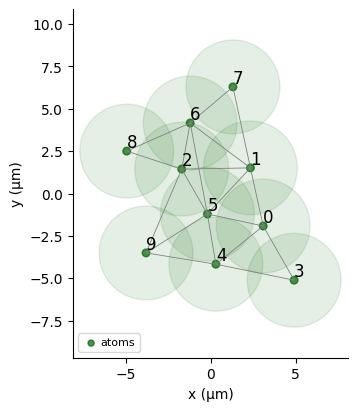

In [6]:
Omega_max = 30 * 2 * np.pi # Maximum
delta_max = Omega_max/5
Rmin = (device_used.interaction_coeff/Omega_max)**(1/6)
R_blockade = Rmin
# print(Rmin)

coords = np.array(list(pos.values())) #extract coordinates from the spring layout
val = np.min(pdist(coords))
coords *= Rmin/val/2 # make sure the minimum distance is 4 um - rescale the register

#On extrait la matrice d'interactions
int_matrix = squareform(device_used.interaction_coeff / pdist(coords) ** 6) #extract the corresponding interaction matrix

# Crée un registre de qubits selon les positions calculées
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Rmin,
    draw_graph=True,
    draw_half_radius=True,
);

Compare the blockade graph (i.e. which atoms are blockaded by which other) with the initial graph's adjacency matrix.

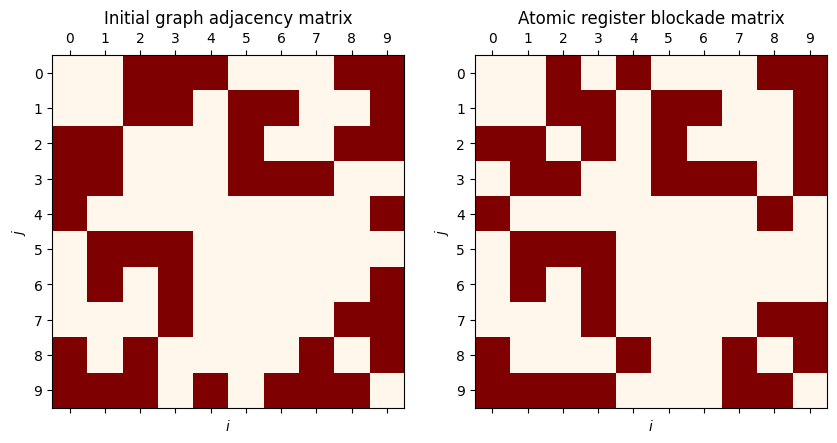

In [43]:
mat_coords = squareform(pdist(coords))
adj_reg = 1.0*(mat_coords < R_blockade)
for i in range(N):
    adj_reg[i,i] = 0
adj_theory = nx.adjacency_matrix(graph).toarray()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
cmap = plt.get_cmap('OrRd')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)

plot_Q = [adj_theory, adj_reg]
# plot_Q = [adj_theory, int_matrix]
titles = ['Initial graph adjacency matrix', 'Atomic register blockade matrix']
k = 0
for ax in axes.flat:

    # Q_plot = plot_Q[k]/np.max(plot_Q[k])
    Q_plot = plot_Q[k]
    norm = mpl.colors.Normalize(vmin=np.min(Q_plot), vmax=np.max(Q_plot))

    img = ax.matshow(Q_plot, cmap=cmap)
    # fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    ax.set_xticks(np.arange(len(Q_plot)))
    ax.set_yticks(np.arange(len(Q_plot)))
    ax.set_xlabel(r'$i$')
    ax.set_ylabel(r'$j$')
    ax.set_title(titles[k])
    k += 1

plt.show()

We see that they are not quite the same, but that the overlap is good. If one wanted to pursue a more general algorithm to improve the embedding, one could design a variational loop where one alters the maximum Rabi ampitude (which controls the blockade radius) and the placement of the atoms so that the difference between these two matrices is minimal. This loop is entirely classical, and serves to improve the embedding process prior to sending the Register and Sequence to the QPU.

We then perform a rise - sweep - fall annealing pulse.

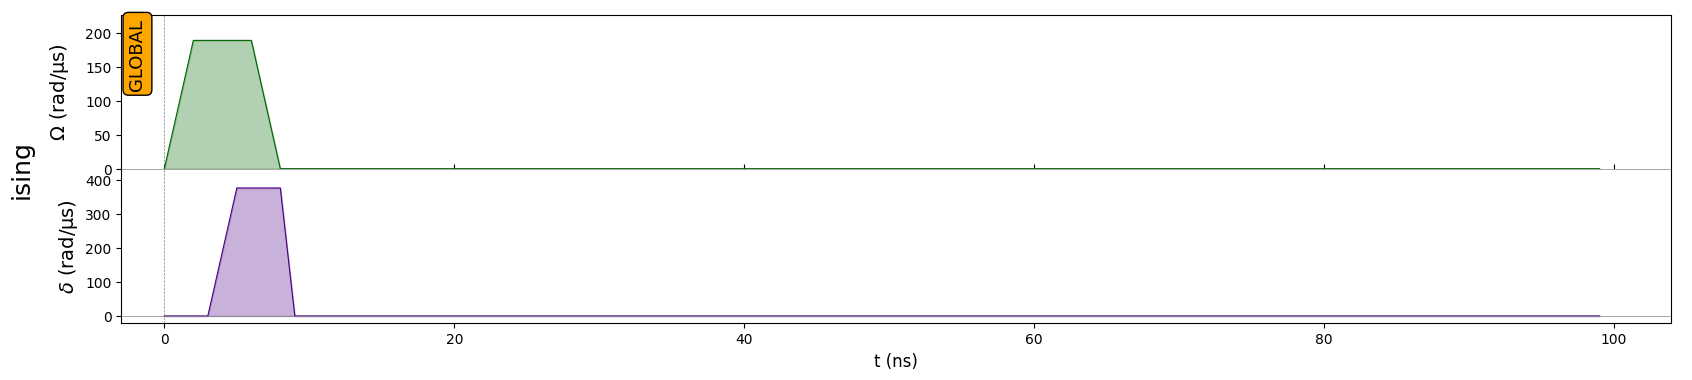

In [10]:
#detuning values
Omega_max = 30 * 2 * np.pi
delta_f = Omega_max*2
#rise, sweep, fall times: these times are in ns
t_rise = 3 
t_sweep = 3
t_fall = 3
#create the pulse shapes
rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), 0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, 0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

#create the sequence
seq = Sequence(reg, MockDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(rise, "ising", "no-delay")
seq.add(sweep, "ising", "no-delay")
seq.add(fall, "ising", "no-delay")
seq.draw()

On simule l'évolution résultant de cette séquence.

In [8]:
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real devic
                                    )
results = simul.run(progress_bar=True)


10.2%. Run time:   0.14s. Est. time left: 00:00:00:01
20.2%. Run time:   0.30s. Est. time left: 00:00:00:01
30.2%. Run time:   0.56s. Est. time left: 00:00:00:01
40.1%. Run time:   1.03s. Est. time left: 00:00:00:01
50.1%. Run time:   1.45s. Est. time left: 00:00:00:01
60.1%. Run time:   1.89s. Est. time left: 00:00:00:01
70.1%. Run time:   2.35s. Est. time left: 00:00:00:01
80.0%. Run time:   2.79s. Est. time left: 00:00:00:00
90.0%. Run time:   3.24s. Est. time left: 00:00:00:00
Total run time:   3.67s


On trace la distribution des résultats, et on colore les bares si la solution est a) mieux que la solution trouvée par NetworkX, b) aussi bonne que la solution trouvée par NetworkX, c) une solution valide moins bonne que la solution trouvée par NetworkX, et d) pas une solution valide.

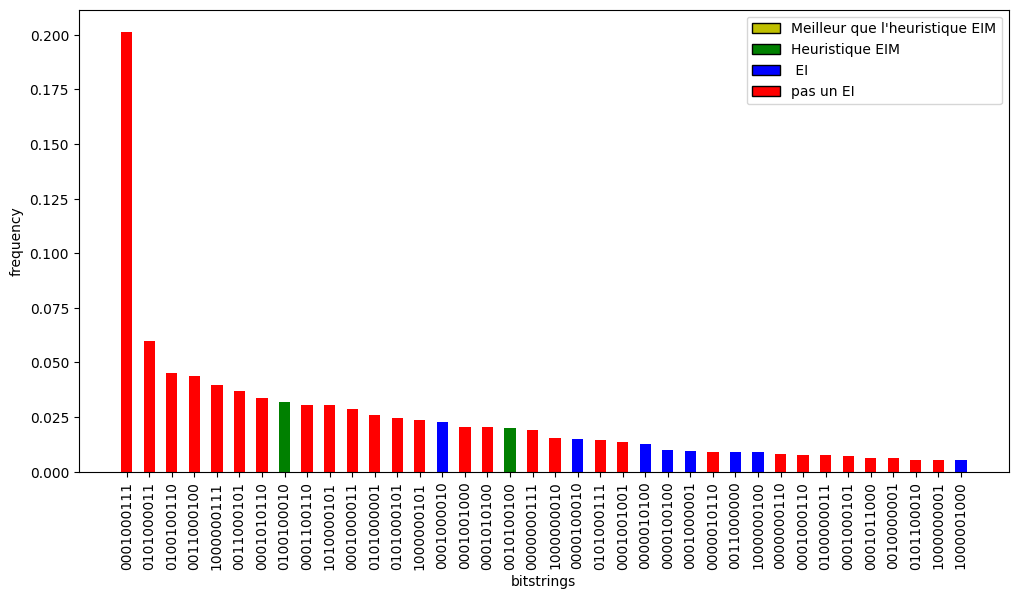

In [9]:
N_samples = 2000
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v/N_samples for k, v in count_dict.items() if v > 0.005*N_samples}
sorted_dict = dict(sorted(most_freq.items(), key=lambda item: item[1], reverse=True))
color_dict = {}
mis_size = len(ind_set)
found_best_bitstrings = []
countsGoodSolution = 0 
for key in sorted_dict:
    if check_IS(key, graph):
        if sum_bit(key) > mis_size:
            color_dict.update({key : "y"})
            found_best_bitstrings.append(key)
            countsGoodSolution += sorted_dict[key]
        elif sum_bit(key) == mis_size:
            color_dict.update({key : "g"})
            countsGoodSolution += sorted_dict[key]
        else:
            color_dict.update({key : "b"})
    else:
        color_dict.update({key : "r"})
plt.figure(figsize=(12, 6))
plt.xlabel("bitstrings")
plt.ylabel("frequency")
plt.bar(sorted_dict.keys(), np.array(list(sorted_dict.values())), width=0.5, color=color_dict.values())
plt.xticks(rotation="vertical")
#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['y','g','b','r']]
labels= ["Meilleur que l'heuristique EIM", "Heuristique EIM"," EI", "pas un EI"]
plt.legend(handles, labels)
plt.show()

Draw the graph for a given bitsting

In [11]:
print(found_best_bitstrings)
print(countsGoodSolution)

[]
0.052000000000000005


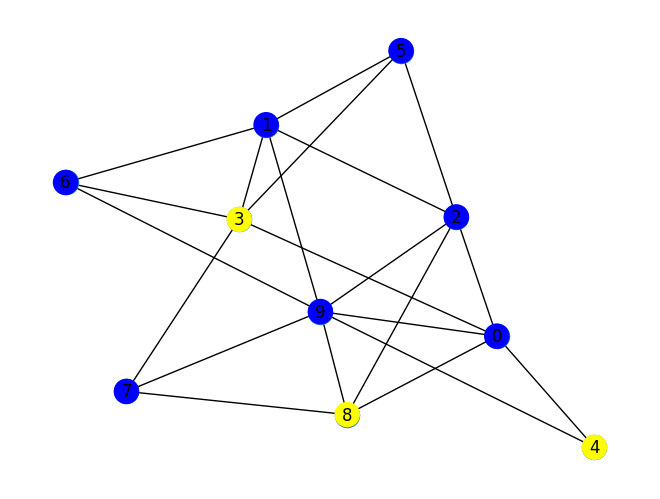

In [12]:
# Ceci est la meilleure solution trouvée par l'algorithme quantique
# bitstring = found_best_bitstrings[-1]
# Ceci est la meilleure solution trouvée par l'algorithme heuristique de NetworkX
bitstring = ind_set_bitstring
nx.draw(graph, pos = pos)
nx.draw_networkx_labels(graph, pos = pos);
node_colors = []
for i in range(len(graph)):
    if bitstring[i] == '0':
        node_colors.append('blue')
    elif bitstring[i] == '1':
        node_colors.append('yellow')
nx.draw_networkx_nodes(graph, pos=pos, node_color = node_colors)
plt.show()